# Distortion of Eiger2 CdTe detector from ID11

The detector's distortion is characterized by a Tungsten plate with a grid pattern of holes provided by Gavin Vaughan. The calibration experiment has been performed by Marie Ruat with a conventional source.
Those files are not available for share, please get in contact with Marie for the experimental details.

## Preprocessing

Data were acquired with and without the grid on from of the detector. 100 frames were recorded in each case withthe same exposure time. 
The first step is to filter out outliers using a pixel-wise median filter on the stack.

*Note:* a faily recent version of FabIO is needed to read those HDF5 files produced by LImA. This notebook uses features available only in version 0.21 of pyFAI (development version for now)

In [1]:
%matplotlib nbagg
import time
import os
start_time = time.perf_counter()
#load many libraries ...
from matplotlib.pyplot import subplots
import matplotlib.colors as colors
import numpy
import pyFAI
from collections import namedtuple
from scipy.ndimage import convolve, binary_dilation, label, distance_transform_edt
from scipy.spatial import distance_matrix
from pyFAI.ext.watershed import InverseWatershed
from pyFAI.ext.bilinear import Bilinear
from pyFAI.utils.grid import Kabsch #Needs pyFAI 0.21!

In [2]:
#Get the grid/flat data and filter them
!wget http://www.silx.org/pub/pyFAI/detector_calibration/Eiger2-ID11/W200um_40kVp_5mA_T4_E8_FF_noretrigger_0000.h5
!wget http://www.silx.org/pub/pyFAI/detector_calibration/Eiger2-ID11/W200um_40kVp_5mA_T4_E8_GRID_noretrigger_0000.h5    
!pyFAI-average -m median W200um_40kVp_5mA_T4_E8_FF_noretrigger_0000.h5 -F numpy -o flat.npy
!pyFAI-average -m median W200um_40kVp_5mA_T4_E8_GRID_noretrigger_0000.h5 -F numpy -o grid.npy

--2021-02-26 13:30:55--  http://www.silx.org/pub/pyFAI/detector_calibration/Eiger2-ID11/W200um_40kVp_5mA_T4_E8_FF_noretrigger_0000.h5
Résolution de www.silx.org (www.silx.org)… 195.154.237.27
Connexion à www.silx.org (www.silx.org)|195.154.237.27|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 758913619 (724M)
Sauvegarde en : « W200um_40kVp_5mA_T4_E8_FF_noretrigger_0000.h5 »

W200um_40kVp_5mA_T4 100%[===================>] 723,76M  56,3MB/s    ds 13s     

2021-02-26 13:31:08 (55,2 MB/s) — « W200um_40kVp_5mA_T4_E8_FF_noretrigger_0000.h5 » sauvegardé [758913619/758913619]

--2021-02-26 13:31:08--  http://www.silx.org/pub/pyFAI/detector_calibration/Eiger2-ID11/W200um_40kVp_5mA_T4_E8_GRID_noretrigger_0000.h5
Résolution de www.silx.org (www.silx.org)… 195.154.237.27
Connexion à www.silx.org (www.silx.org)|195.154.237.27|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 484110560 (462M)
Sauvegarde en : « W200um_40kVp_5mA_T4_E8_G

In [3]:
# A couple of constants and compound dtypes ...
dt = numpy.dtype([('y', numpy.float64),
                  ('x', numpy.float64),
                  ('i', numpy.int64),
                 ])
mpl = {"cmap":"viridis", 
       "interpolation":"nearest"}
print("Using pyFAI verison: ", pyFAI.version)

Using pyFAI verison:  0.21.0-dev0


<IPython.core.display.Javascript object>


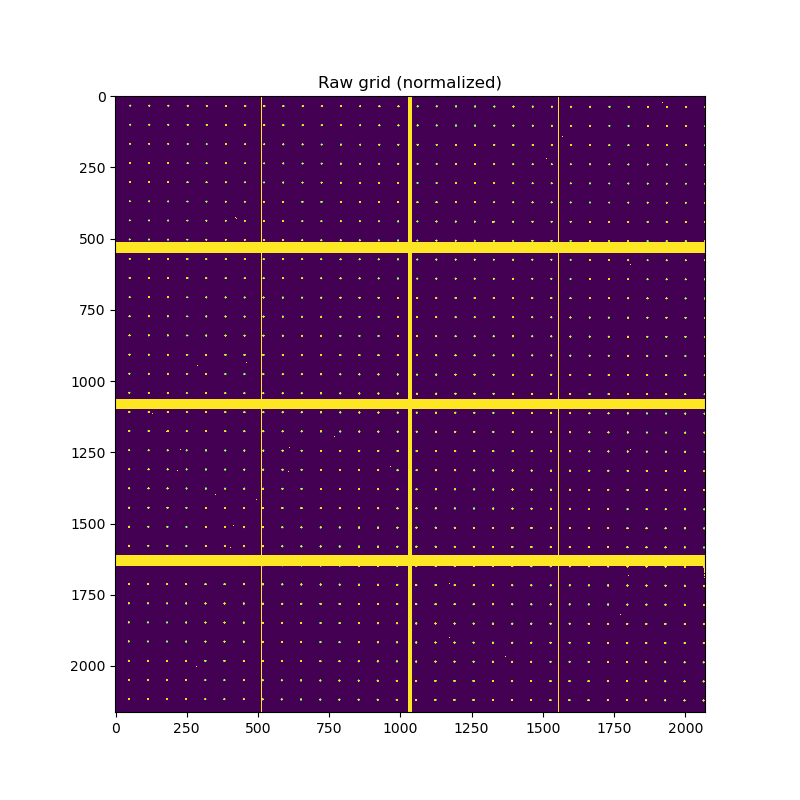

In [4]:
flat = numpy.load("flat.npy")
grid = numpy.load("grid.npy")
fig, ax = subplots(figsize=(8,8))

ax.imshow(grid/flat, **mpl)
ax.set_title("Raw grid (normalized)")
pass

## Define the right mask

As we want to measure the position of the grid with a sub-pixel precision, it is of crutial important to discard all pixels wich have been interpolated.

The Eiger2 4M is built of 8 modules 500 kpixels, each of them consists of the assemble of 8 chips of 256x256 pixel each. Some pixels are systematically masked out as they are known to be noisy. Some pixels are also missing at the junction of the sub-modules. Finally the CdTe sensors is made of single crystals of the semi-conductor which cover 512x512 pixels. Hence one sensor covers half a module or 4 chips.

This is best demonstrated by the pixel-wise standard deviation along a stack of images like the one acquired for the flatfield.

A Poissonian detector should have a variance equal to the average signal. Thus plotting the standard deviation squared over the median highlights:
 * Noisy pixels which should be discarded for quantitative analysis std²>>median
 * Interpolated pixels which have only half/quater of the expected noise (std²<<median).
 
The detector has also an internal map of invalid pixel which are set to the maximum value of the range.

In [5]:
!pyFAI-average -m std W200um_40kVp_5mA_T4_E8_FF_noretrigger_0000.h5 -F numpy -o flat_std.npy

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
Std reduction finished                                                                                         


<IPython.core.display.Javascript object>


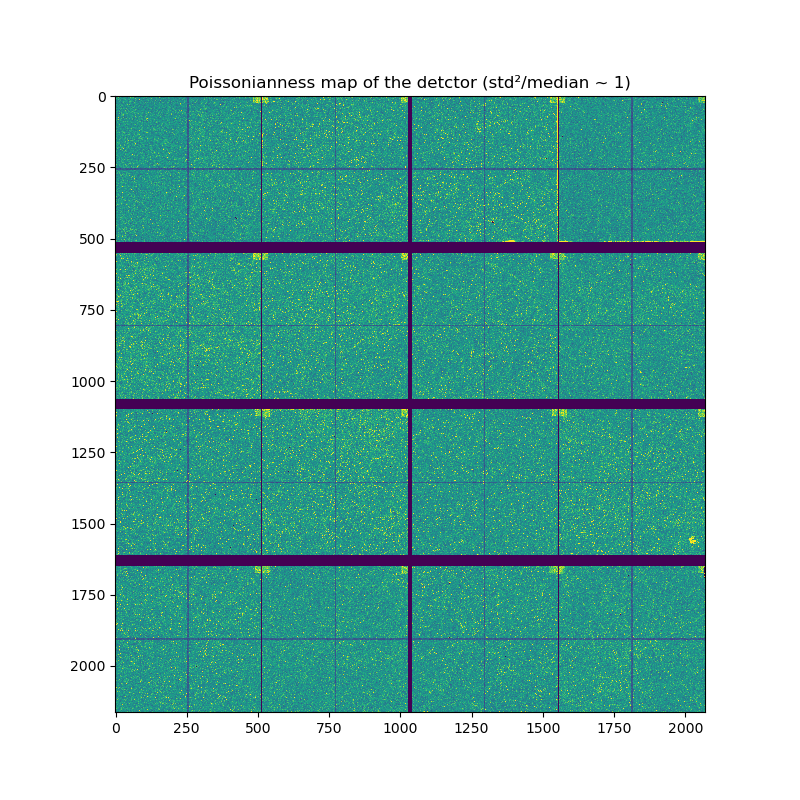

In [6]:
std = numpy.load("flat_std.npy")
fig, ax = subplots(figsize=(8,8))
ax.imshow((std**2/flat).clip(0,2), **mpl)
ax.set_title("Poissonianness map of the detctor (std²/median ~ 1)")
pass

<IPython.core.display.Javascript object>


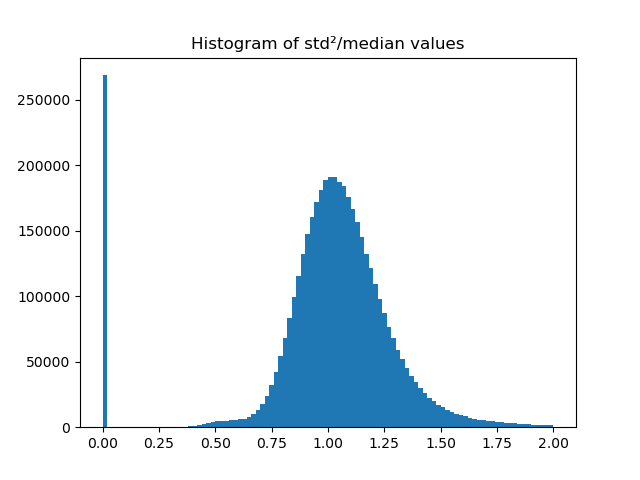

In [7]:
fig, ax = subplots()
ax.hist((std**2/flat).ravel(), 100, range=(0,2))
ax.set_title("Histogram of std²/median values")
pass

This test of Poissonian-ness is not enough to discriminate between interpolated pixels and non interpolated ones.
One needs to build the mask by other methods.

In [8]:
# This is the default detector as definied in pyFAI according to the specification provided by Dectris:
eiger2 = pyFAI.detector_factory("Eiger2CdTe_4M")
width = eiger2.shape[1]
module_size = eiger2.MODULE_SIZE
module_gap = eiger2.MODULE_GAP
submodule_size = (256,256)

In [9]:
#Calculate the default mask
mask = eiger2.calc_mask()
# Mask out the interpolated pixels along X
for j in [256, 772]:
    for i in range(j, eiger2.max_shape[1],
                   eiger2.module_size[1] + eiger2.MODULE_GAP[1]):
        mask[:,i-2:i + 2] = 1
# Mask out the interpolated pixels along Y
for i in range(256, eiger2.max_shape[0],
               eiger2.module_size[0] + eiger2.MODULE_GAP[0]):
    mask[i-2:i + 2, :] = 1

# mask out the border pixels:
mask[0] = 1
mask[-1] = 1
mask[:, 0] = 1
mask[:, -1] = 1
    
# Finally mask out invalid/miss-behaving pixels known from the detector
mask[ flat>(flat.max()*0.99) ] = 1

<IPython.core.display.Javascript object>


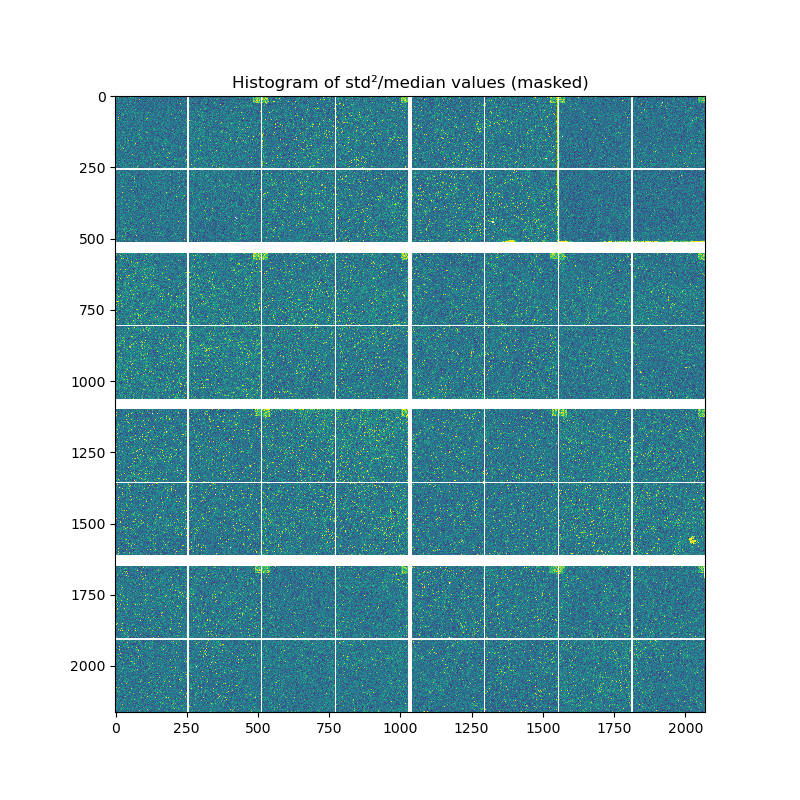

In [10]:
pois = (std**2/flat).clip(0,2)
pois[numpy.where(mask)] = numpy.NAN
fig, ax = subplots(figsize=(8,8))
ax.imshow(pois, **mpl)
ax.set_title("Histogram of std²/median values (masked)")
pass

<IPython.core.display.Javascript object>


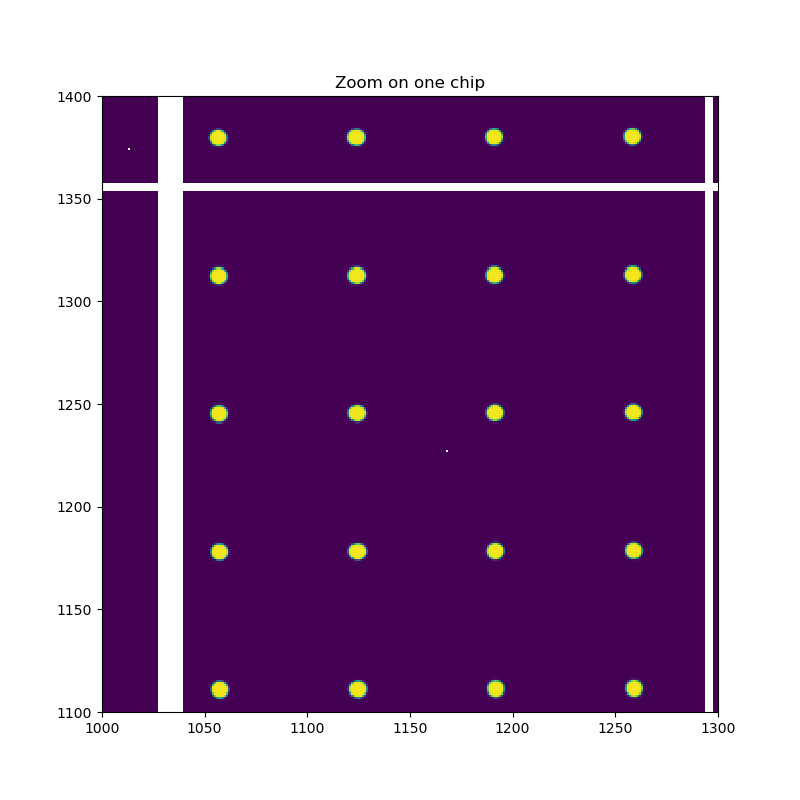

In [11]:
normalized = grid/flat
normalized[numpy.where(mask)] = numpy.NaN
fig, ax = subplots(figsize=(8,8))
ax.imshow(normalized, **mpl)
ax.set_ylim(1100,1400)
ax.set_xlim(1000,1300)
ax.set_title("Zoom on one chip")
pass

We can see we have between 8 and 16 grid spots per sub-module. This is enough as 3 are needed to localize precisely the position of the chip.

## Grid spot position measurement.

Let's measure the position of the grid spots precisely. For this we perform a convolution with a kernel which looks like the spot itself. By zooming onto one spot, it is roughly 10 pixels wide, the kernel needs to be of odd size. The fade-out function is tuned to set precisely the spot diameter.

The masked values have been set to NaN, this ensures any spot close to a masked region get discarded automatically.

Integral of the kernel:  64.79908175810988


<IPython.core.display.Javascript object>


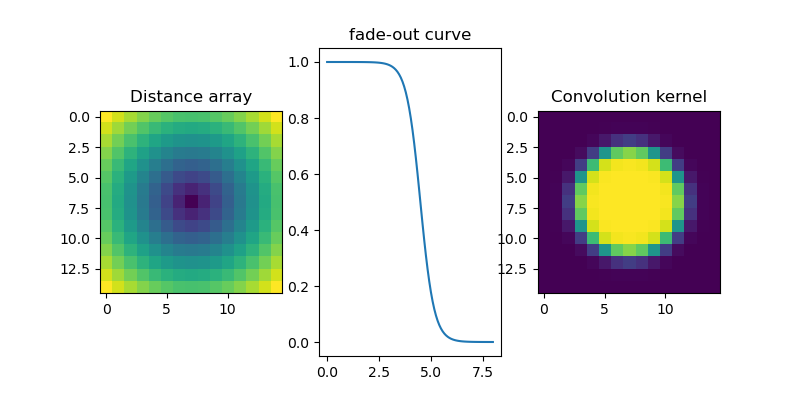

In [12]:
#Definition of the convolution kernel
ksize = 15
y,x = numpy.ogrid[-(ksize-1)//2:ksize//2+1,-(ksize-1)//2:ksize//2+1]
d = numpy.sqrt(y*y+x*x)

#Fade out curve definition
fadeout = lambda x: 1/(1+numpy.exp(3*(x-4.5)))

kernel = fadeout(d)
mini=kernel.sum()
print("Integral of the kernel: ", mini)

fig,ax = subplots(1,3, figsize=(8,4))
ax[0].imshow(d)
ax[0].set_title("Distance array")

ax[1].plot(numpy.linspace(0,8,100),fadeout(numpy.linspace(0,8,100)))
ax[1].set_title("fade-out curve")

ax[2].imshow(kernel)
ax[2].set_title("Convolution kernel")
pass

<IPython.core.display.Javascript object>


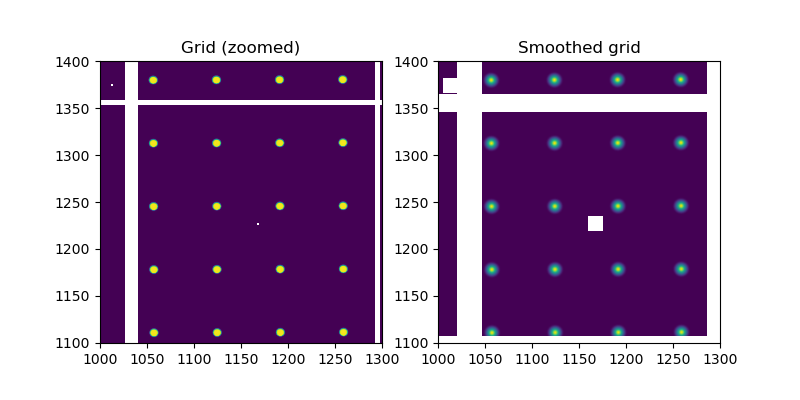

In [13]:
smooth = convolve(normalized, kernel, mode="constant", cval=0)/mini
fig,ax = subplots(1,2, figsize=(8,4))
ax[0].imshow(normalized)
ax[0].set_ylim(1100,1400)
ax[0].set_xlim(1000,1300)
ax[1].imshow(smooth)
ax[1].set_ylim(1100,1400)
ax[1].set_xlim(1000,1300)

ax[0].set_title("Grid (zoomed)")
ax[1].set_title("Smoothed grid")
pass

In [14]:
# Calculate a mask with all pixels close to any gap is discared
#big_mask = numpy.isnan(smooth)
big_mask = binary_dilation(numpy.isnan(smooth), iterations=ksize//2+2) #even a bit larger
#big_mask = binary_dilation(mask, iterations=ksize) #Extremely conservative !

## Peak position measurement

The center of spot is now easily measured by segmenting out the image

In [15]:
iw = InverseWatershed(smooth)
iw.init()
iw.merge_singleton()
all_regions = set(iw.regions.values())

regions = [i for i in all_regions if i.size>mini]

print("Number of region segmented: %s"%len(all_regions))
print("Number of large enough regions : %s"%len(regions))

Number of region segmented: 837882
Number of large enough regions : 5968


<IPython.core.display.Javascript object>


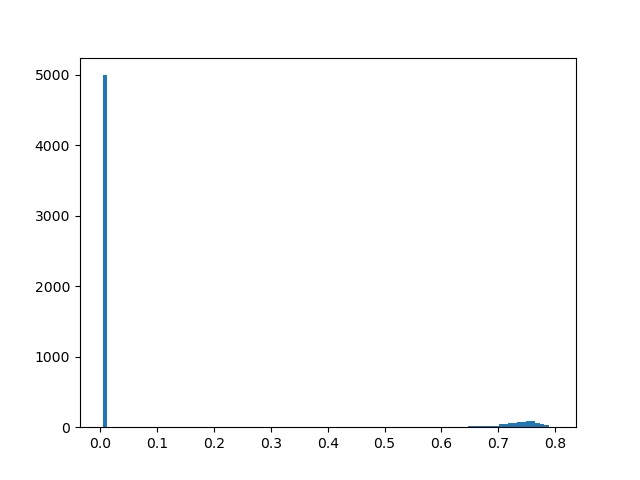

In [16]:
# Histogram of peak height:
s = numpy.array([i.maxi for i in regions])

fig, ax = subplots()
ax.hist(s, 100)
pass

In [17]:
#Sieve-out for peak intensity
int_mini = 0.5

peaks = [(i.index//width, i.index%width) for i in regions if (i.maxi)>int_mini and 
                             not big_mask[(i.index//width, i.index%width)]]
print("Number of remaining peaks with I>%s: %s"%(int_mini, len(peaks)))

peaks_raw = numpy.array(peaks)

Number of remaining peaks with I>0.5: 694


About 800 spots were found as valid out of a maximum of 1024 (64 chips with 16 spots per chip)

Those spot positions are interpolated using a second order taylor expansion in the region around the maximum value of the smoothed image.

In [18]:
#Use a bilinear interpolator to localize/refine the maxima
bl = Bilinear(smooth)
ref_peaks = [bl.local_maxi(p) for p in peaks]

<IPython.core.display.Javascript object>


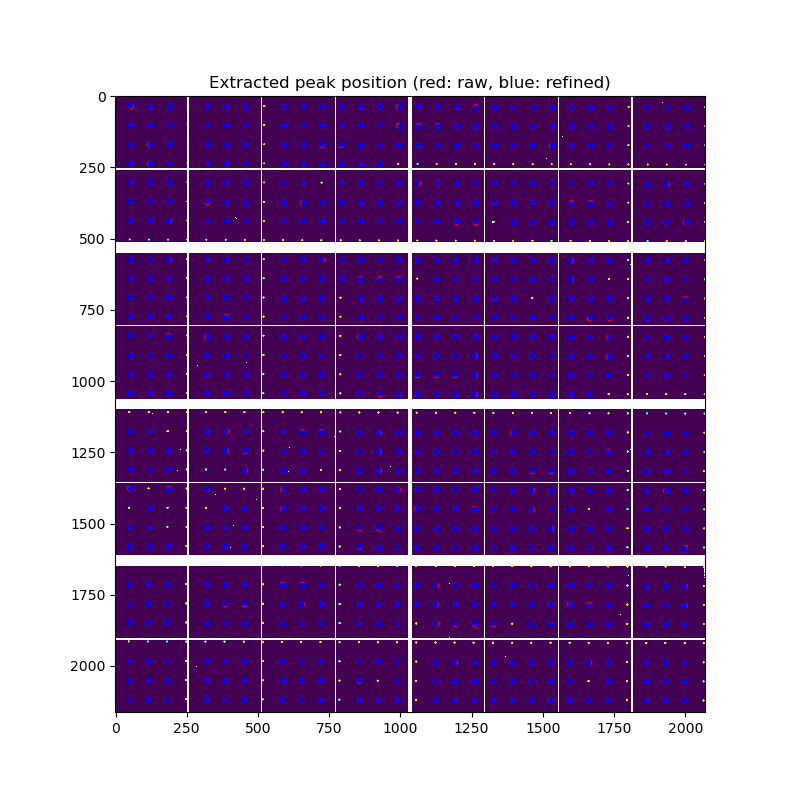

Refined peak coordinate: [(35.685219407081604, 926.1952172219753), (35.78912889957428, 993.4327814280987), (35.97768804244697, 1060.179537087679), (36.05387208610773, 1127.3943344652653), (36.21792732179165, 1194.6735018193722), (36.40029862523079, 1261.8895630538464), (36.59907326102257, 1329.1165300160646), (36.67006212472916, 1396.3771429657936), (36.97551264986396, 1530.8204399496317), (37.13566243648529, 1598.017841808498)] ...


In [19]:
#Overlay raw peak coordinate and refined peak positions
fig, ax = subplots(figsize=(8,8))
ax.imshow(normalized, **mpl)
peaks_ref = numpy.array(ref_peaks)
ax.plot(peaks_raw[:,1], peaks_raw[:, 0], ".r")
ax.plot(peaks_ref[:,1],peaks_ref[:, 0], ".b")
ax.set_title("Extracted peak position (red: raw, blue: refined)")
print("Refined peak coordinate:", ref_peaks[:10], "...")

At this stage we have about 800 peaks (with sub-pixel precision) which are visually distributed on all modules and on all chips.
We could have expected 16*64=1024 hence most of the spots were properly located.

Let's assign each peak to a module identifier. This allows to print out the number of peaks per module:

In [20]:
#Module identification
mid, cnt = label(numpy.isfinite(normalized), structure=numpy.ones((3,3), dtype=int))
print(cnt, "chips have been labeled")

64 chips have been labeled


In [21]:
# Fill the gaps in module identification array

#From http://stackoverflow.com/questions/3662361/fill-in-missing-values-with-nearest-neighbour-in-python-numpy-masked-arrays
def fill(data, invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid') 
    by the value of the nearest valid data cell

    Input:
        data:    numpy array of any dimension
        invalid: a binary array of same shape as 'data'. True cells set where data
                 value should be replaced.
                 If None (default), use: invalid  = np.isnan(data)

    Output: 
        Return a filled array. 
    """

    if invalid is None: 
        invalid = numpy.isnan(data)

    ind = distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]

filled_mid = fill(mid, invalid=mid==0)

<IPython.core.display.Javascript object>


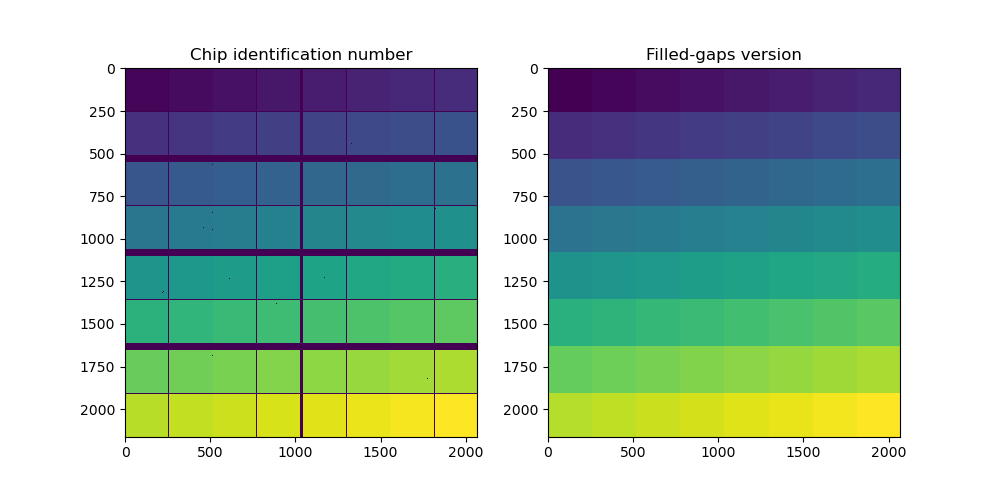

In [22]:
fig,ax = subplots(1, 2, figsize=(10,5))
ax[0].imshow(mid, **mpl)
ax[0].set_title("Chip identification number")
ax[1].imshow(filled_mid, **mpl)
ax[1].set_title("Filled-gaps version")
pass

In [23]:
yxi = numpy.array([i+(mid[round(i[0]),round(i[1])],) 
                   for i in ref_peaks], dtype=dt)
print("Number of keypoint per chip:")
for i in range(1, cnt+1):
    print(f"Chip id: {i:2d} \t Number of spots: {(yxi[:]['i'] == i).sum():2d}")

Number of keypoint per chip:
Chip id:  1 	 Number of spots: 12
Chip id:  2 	 Number of spots: 12
Chip id:  3 	 Number of spots: 12
Chip id:  4 	 Number of spots: 15
Chip id:  5 	 Number of spots: 12
Chip id:  6 	 Number of spots: 12
Chip id:  7 	 Number of spots:  9
Chip id:  8 	 Number of spots:  9
Chip id:  9 	 Number of spots:  9
Chip id: 10 	 Number of spots:  9
Chip id: 11 	 Number of spots:  8
Chip id: 12 	 Number of spots: 12
Chip id: 13 	 Number of spots: 12
Chip id: 14 	 Number of spots: 11
Chip id: 15 	 Number of spots:  9
Chip id: 16 	 Number of spots:  9
Chip id: 17 	 Number of spots: 12
Chip id: 18 	 Number of spots: 12
Chip id: 19 	 Number of spots: 12
Chip id: 20 	 Number of spots: 14
Chip id: 21 	 Number of spots: 15
Chip id: 22 	 Number of spots: 15
Chip id: 23 	 Number of spots: 11
Chip id: 24 	 Number of spots: 12
Chip id: 25 	 Number of spots: 12
Chip id: 26 	 Number of spots: 12
Chip id: 27 	 Number of spots: 12
Chip id: 28 	 Number of spots: 12
Chip id: 29 	 Numbe

## Grid assignment

The calibration is performed using a regular grid, the idea is to assign to each peak of coordinates (x,y) the integer value (X, Y) which correspond to the grid corrdinate system.

The first step is to measure the grid pitch which correspond to the distance (in pixels) from one peak to the next. This is easily obtained from a pair-wise distribution function.


<IPython.core.display.Javascript object>


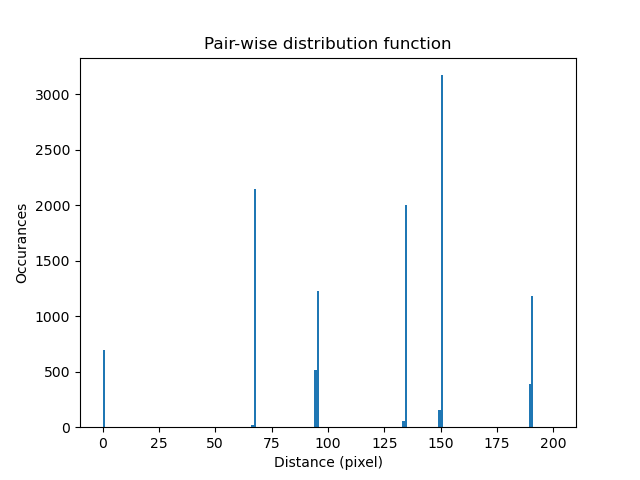

In [24]:
# pairwise distance calculation using scipy.spatial.distance_matrix

dist = distance_matrix(peaks_ref, peaks_ref)

fig, ax = subplots()
ax.hist(dist.ravel(), 200, range=(0,200))
ax.set_title("Pair-wise distribution function")
ax.set_xlabel("Distance (pixel)")
ax.set_ylabel("Occurances")
pass

The histogram of the pair-distribution function has a first peak at 0 and the second peak between 66 and 67.
The value of the step size is taken as the average of this second peak in the histogram as it correspond to the first neighbour distance.

Two other parameters correspond to the offset, in pixels, for the grid index (X,Y) = (0,0). The easiest is to measure the smallest x and y for the first chip.

The grid looks pretty well aligned with the detector, so we will not take into account the rotation of the grid with the detector.

In [25]:
#from pair-wise distribution histogram
valid_pairs = dist[numpy.logical_and(60<dist, dist<70)]
step = valid_pairs.mean()
print("Average step size", step, "±", valid_pairs.std(), " pixels, condidering ", valid_pairs.size, "paires")

Average step size 67.2043508651196 ± 0.07395487014128002  pixels, condidering  2170 paires


In [26]:
#Refinement of the step size when considering only intra-chip distances.
distances = []
for i in range(1, cnt+1):
    locale = yxi[yxi[:]["i"] == i]
    xy = tmp = numpy.vstack((locale["x"], locale["y"])).T
    ldist = distance_matrix(tmp, tmp)
    distances.append(ldist[numpy.logical_and(60<ldist, ldist<70)])
valid_pairs = numpy.concatenate(distances)
step = valid_pairs.mean()
print("Average step size", step, "±", valid_pairs.std(), " pixels, condidering ", valid_pairs.size, "paires")

Average step size 67.20456994646801 ± 0.060251562866079335  pixels, condidering  1888 paires


It is interesting to note the standard deviation (0.12) corresponds to the precision of our measurement. 

Any tweaking when defining the kernel prior to the convolution should be checked against this error.

Finally, it will not be possible to calibrate with a precision better than 0.12 pixel.

In [27]:
#work with the first module and fit the peak positions
first = yxi[yxi[:]["i"] == 1]
y_min = first[:]["y"].min()
x_min = first[:]["x"].min()
print("offset for the first spot: ", x_min, y_min)

offset for the first spot:  52.002443285193294 32.73367238044739


The grid looks very well aligned with the axes which makes this step easier but nothing garanties it is perfect, so the rotation of the grid has to be measured as well.
We will use Kabsch's algoritm for this: https://en.wikipedia.org/wiki/Kabsch_algorithm


In [28]:
reference_1 = numpy.empty((first.size, 2))
measured_1 = numpy.empty((first.size, 2))
measured_1[:, 0] = first[:]["x"]
measured_1[:, 1] = first[:]["y"]
reference_1[:, 0] = numpy.round((first[:]["x"]-x_min)/step)*step+x_min
reference_1[:, 1] = numpy.round((first[:]["y"]-y_min)/step)*step+y_min
%time Kabsch(reference_1, measured_1)

CPU times: user 0 ns, sys: 474 µs, total: 474 µs
Wall time: 466 µs


Rigid transformation of angle -0.167° and translation [[-0.67497994  0.07186018]], RMSD=0.168643

In [29]:
# Print alignment info for  all chips:
kabsch_results = {}
raw_distances = []
distances = []
for i in range(1, cnt+1):
    local = yxi[yxi[:]["i"] == i]
    reference = numpy.empty((local.size, 2))
    measured = numpy.empty((local.size, 2))
    measured[:, 0] = local[:]["x"]
    measured[:, 1] = local[:]["y"]
    reference[:, 0] = numpy.round((local[:]["x"]-x_min)/step)*step+x_min
    reference[:, 1] = numpy.round((local[:]["y"]-y_min)/step)*step+y_min
    raw_distances.append(numpy.sqrt(((reference-measured)**2).sum(axis=-1)))
    res = kabsch_results[i] = Kabsch(reference, measured)
    print(f"Chip: {i:02d} \t Rmsd: {res.rmsd:.4f} \t Angle: {res.angle:.4f}°\t Displacement: {res.translation}")
    distances.append(numpy.sqrt(((reference-res.correct(measured))**2).sum(axis=-1)))

Chip: 01 	 Rmsd: 0.1686 	 Angle: -0.1671°	 Displacement: [[-0.67497994  0.07186018]]
Chip: 02 	 Rmsd: 0.1700 	 Angle: -0.1780°	 Displacement: [[-0.74921418  0.03713335]]
Chip: 03 	 Rmsd: 0.1497 	 Angle: -0.1825°	 Displacement: [[-0.65099039 -0.06528471]]
Chip: 04 	 Rmsd: 0.1674 	 Angle: -0.1775°	 Displacement: [[-0.60887024 -0.07475025]]
Chip: 05 	 Rmsd: 0.1677 	 Angle: -0.1230°	 Displacement: [[-0.2155431  -0.96577617]]
Chip: 06 	 Rmsd: 0.1752 	 Angle: -0.1200°	 Displacement: [[-0.29661047 -1.06085984]]
Chip: 07 	 Rmsd: 0.1720 	 Angle: -0.1461°	 Displacement: [[-0.44852505 -0.32922427]]
Chip: 08 	 Rmsd: 0.1676 	 Angle: -0.1368°	 Displacement: [[-0.6149567 -0.5646288]]
Chip: 09 	 Rmsd: 0.1153 	 Angle: -0.1940°	 Displacement: [[-0.79676554  0.08513204]]
Chip: 10 	 Rmsd: 0.1765 	 Angle: -0.1774°	 Displacement: [[-0.71245072  0.00897699]]
Chip: 11 	 Rmsd: 0.2042 	 Angle: -0.1751°	 Displacement: [[-0.60947848 -0.15400732]]
Chip: 12 	 Rmsd: 0.1760 	 Angle: -0.1781°	 Displacement: [[-0.61303

<IPython.core.display.Javascript object>


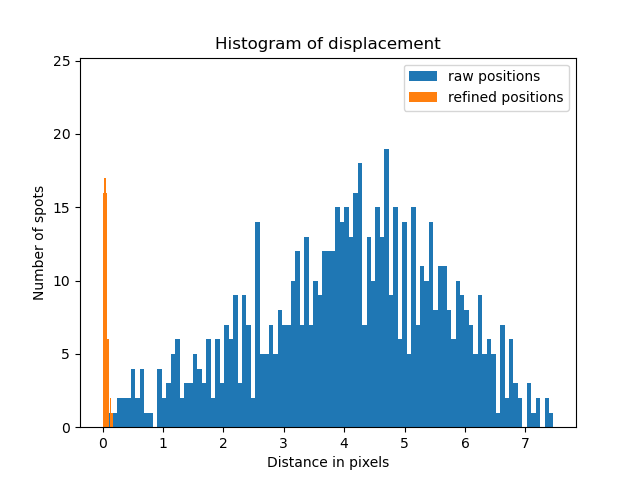

In [30]:
ndistances = numpy.concatenate(distances)
nraw_distances = numpy.concatenate(raw_distances)

fig, ax = subplots()
ax.hist(nraw_distances, bins=100, label="raw positions")
ax.hist(ndistances, bins=100, label="refined positions")
ax.set_title("Histogram of displacement")
ax.set_xlabel("Distance in pixels")
ax.set_ylabel("Number of spots")
ax.legend()
pass

## Reconstruction of the pixel position

The pixel position can be obtained from the standard Pilatus detector. Each module is then displaced according to the fitted values.

In [31]:
%%time 
pixel_coord = pyFAI.detector_factory("Eiger2CdTe_4M").get_pixel_corners().astype(numpy.float64)
pixel_coord_raw = pixel_coord.copy()

for module in range(1, cnt+1):
    # Extract the pixel corners for one module
    module_idx = numpy.where(filled_mid  == module)
    one_module = pixel_coord_raw[module_idx]


    #retrieve the fitted values
    res = kabsch_results[module]

    #z = one_module[...,0]
    y = one_module[...,1].ravel()/eiger2.pixel1
    x = one_module[...,2].ravel()/eiger2.pixel2
    xy_initial = numpy.vstack((x, y)).T
    xy_aligned = res.correct(xy_initial)
    
    one_module[...,1] = (xy_aligned[:,1] * eiger2.pixel1).reshape(one_module.shape[:-1])
    one_module[...,2] = (xy_aligned[:,0] * eiger2.pixel2).reshape(one_module.shape[:-1])
    #Update the array
    pixel_coord[module_idx] = one_module

CPU times: user 1.58 s, sys: 124 ms, total: 1.7 s
Wall time: 1.7 s


In [32]:
# displacement for every pixel corner (before/after global displacement):
displ_refined = numpy.sqrt(((pixel_coord - pixel_coord_raw)**2).sum(axis=-1))/eiger2.pixel1

global_ref = Kabsch(pixel_coord_raw.reshape((-1, 3)), pixel_coord.reshape((-1, 3)))
new_pixel_coord = global_ref.correct(pixel_coord.reshape((-1, 3))).reshape(pixel_coord_raw.shape)
displ_aligned = numpy.sqrt(((new_pixel_coord - pixel_coord_raw)**2).sum(axis=-1))/eiger2.pixel1

<IPython.core.display.Javascript object>


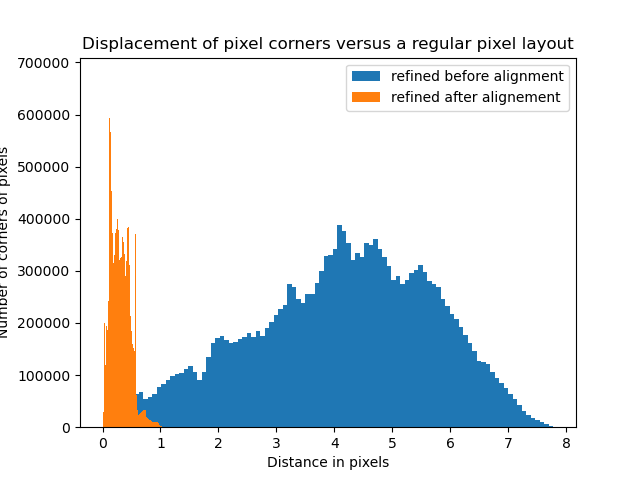

In [33]:
fig, ax = subplots()
ax.hist(displ_refined.ravel(), 100, label="refined before alignment")
ax.hist(displ_aligned.ravel(), 100, label="refined after alignement")
ax.set_title("Displacement of pixel corners versus a regular pixel layout")
ax.set_xlabel("Distance in pixels")
ax.set_ylabel("Number of corners of pixels")
ax.legend()
pass

## Validation of the distortion

To validate the new pixel layout, we can use the new grid to calculate the spot postition in space and look how well aligned they are.

First we build a function which performes the bilinear interpolation of any detector coordinate (return a 3D position). This function is then used to calculate the position for the original grid and for the corrected grid.

As previouly, all spot distances are calculated and histogrammed. The standard deviation is used to evaluate how much was gained.


In [34]:
def intepolate_3d(yx, coord=pixel_coord_raw):
    y,x = yx
    X = int(x)
    Y = int(y)
    pixel =  coord[Y,X]
    #print(pixel)
    dx = x - X
    dy = y - Y
    res = pixel[0]*(1.0-dx)*(1.0-dy)+\
          pixel[3]*dx*(1.0-dy)+\
          pixel[1]*(1.0-dx)*dy+\
          pixel[2]*dx*dy
    return res
intepolate_3d((0.99,0.01))

array([0.00000000e+00, 7.42500035e-05, 7.50000036e-07])

In [35]:
raw_pixel_64 = pixel_coord_raw.astype("float64")/eiger2.pixel1
new_pixel_64 = new_pixel_coord.astype("float64")/eiger2.pixel1

spot3d_raw = numpy.array([intepolate_3d(i, coord=raw_pixel_64) for i in ref_peaks])
spot3d_ref = numpy.array([intepolate_3d(i, coord=new_pixel_64) for i in ref_peaks])

dist_raw = distance_matrix(spot3d_raw, spot3d_raw)
valid_raw = dist_raw[numpy.logical_and(65<dist_raw, dist_raw<70)]

dist_ref = distance_matrix(spot3d_ref, spot3d_ref)
valid_ref = dist_ref[numpy.logical_and(65<dist_ref, dist_ref<70)]

<IPython.core.display.Javascript object>


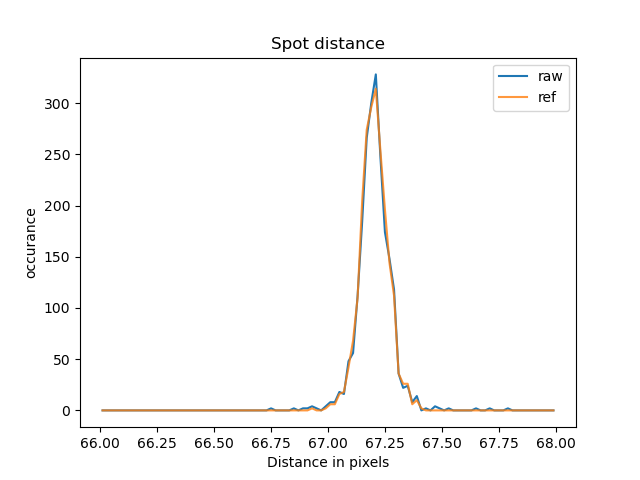

In [36]:
fig,ax = subplots()
h_raw = numpy.histogram(valid_raw, 100, range=(66, 68))
h_ref = numpy.histogram(valid_ref, 100, range=(66, 68))
x = 0.5*(h_raw[1][1:]+h_raw[1][:-1])
ax.plot(x, h_raw[0], label="raw")
ax.plot(x, h_ref[0], label="ref", alpha=0.8)
ax.legend()
ax.set_title("Spot distance")
ax.set_xlabel("Distance in pixels")
ax.set_ylabel("occurance")
pass

In [37]:
print(f"Distance before: {valid_raw.mean():.4f} after {valid_ref.mean():.4f},\nDeviation before {valid_raw.std():.4f}, after {valid_ref.std():.4f}")

Distance before: 67.2044 after 67.2035,
Deviation before 0.0740, after 0.0607


In [38]:
#Saving of the result as a distortion file usable in pyFAI
dest = "Eiger2CdTe_4M_ID11.h5"
if os.path.exists(dest):
    os.unlink(dest)
eiger2.set_pixel_corners(new_pixel_coord.astype(numpy.float32))
eiger2.mask = eiger2.calc_mask() + flat>(flat.max()*0.9)
eiger2.save(dest)

## Conclusion

The distortion measured on the Eiger2 CdTe 4M detector for ID11 looks so small that it hardly deserves correction for module misalignment.

In [39]:
print(f"Total execution time: {time.perf_counter()-start_time:.3f}s")

Total execution time: 69.999s
